# Hurricane Path Predictor
Predicts which zones a hurricane will hit based on past hurricane data. The US National Hurricane Center provided a dataset of hurricane information from 1851 to 2016 in their HURDAT2 dataset.

![alt text](USA_zones.png)
<center>(Figure 1) Hurricane Zones</center>

### Key Terms

**Storm Status Codes**
* WV - Tropical Wave
* TD - Tropical Depression
* TS - Tropical Storm
* HU - Hurricane
* EX - Extratropical cyclone
* SD - Subtropical depression (winds <34 kt)
* SS - Subtropical storm (winds >34 kt)
* LO - A low pressure system not fitting any of above descriptions
* DB - non-tropical Disturbance not have a closed circulation

"Event" refers to the time-series of measurements of one storm

### Importing the Data

Importing python modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

Customizing graphs

In [2]:
custom_style = {'axes.axisbelow': True,
                'axes.edgecolor': 'white',
                'axes.facecolor': '#3C4053',
                'axes.facecolor':'#3C4053',
                'figure.facecolor':'#3C4053',
                'axes.grid': True,
                'axes.labelcolor': 'grey',
                'axes.linewidth': 0,
                'grid.color': 'grey',
                'grid.linestyle': '-',
                'image.cmap': 'Greys',
                'legend.frameon': False,
                'legend.numpoints': 1,
                'legend.scatterpoints': 1,
                'lines.solid_capstyle': 'round',
                'pdf.fonttype': 42,
                'text.color': 'white',
                'xtick.color': 'white',
                'xtick.direction': 'out',
                'xtick.major.size': 0,
                'xtick.minor.size': 0,
                'ytick.color': 'white',
                'ytick.direction': 'out',
                'ytick.major.size': 0,
                'ytick.minor.size': 0}
sns.set(font_scale=1.7, style='darkgrid', rc=custom_style)

Read .csv file line-by-line

In [3]:
with open('hurdat2-1851-2016-041117.csv', 'r') as f: 
       file_data = [row.strip().split(',') for row in f]

Convert data file to data frame

In [4]:
df = pd.DataFrame(file_data)

### Cleaning the Data

Delete columns with missing or incomplete data

In [5]:
df.drop([2] + list(range(7,21)), axis='columns', inplace=True)

Renaming columns

In [6]:
data = pd.DataFrame(np.matrix(df),
                    columns=['date', 'time', 'status', 'lat', 'lon', 'max_wind'])

Encoding the header row for a new hurricane storm

In [7]:
def time_convert(time_str):
    try:
        return(int(time_str.strip()))
    except:
        pass
data.date = data.date.apply(lambda x: '99999999' if x[0] == 'A' else x.strip())
data.time = data.time.apply(lambda x: x.strip())
data.status = data.status.apply(lambda x: 'NE' if x == '' else x.strip())
data.lat = data.lat.apply(lambda x: '00.0N' if x is None else x.strip())
data.lon = data.lon.apply(lambda x: '00.0W' if x is None else x.strip())
data.max_wind = data.max_wind.apply(lambda x: 0 if x is None else int(x.strip()))

Only 'North' latitudes in the data set

In [8]:
lst = []
for x in data.lat:
    if x is not None:
        lst.append(x[-1])
lst = set(lst)
print(lst)

{'N'}


'West' and 'East' longitudes in the data set

In [9]:
lst = []
for x in data.lon:
    if x is not None:
        lst.append(x[-1])
lst = set(lst)
print(lst)

{'W', 'E'}


Converting latitude to float data type

In [10]:
data.lat = data.lat.apply(lambda x: float(x.strip()[:-1]))

Converting longitude to float data type

In [11]:
def lon_convert(lon):
    lon = lon.strip()
    lon_sign = 1
    if lon[-1] == 'W':
        lon_sign = -1
    return(lon_sign * float(lon[:-1]))
data.lon = data.lon.apply(lambda x: lon_convert(x))
data = data[data.lon > -200]    # Dropping noise

Identifying noise in the time column

In [12]:
def time_filter(t):
    try:
        int(t)
        return(t)
    except:
        return('9999')
data.time = data.time.apply(lambda x: time_filter(x))

Extract date information

In [13]:
data.loc[:, 'year'] = data.date.apply(lambda x: int(x[0:4]))
data.loc[:, 'month'] = data.date.apply(lambda x: int(x[4:6]))
data.loc[:, 'day'] = data.date.apply(lambda x: int(x[6:8]))
data.drop('date', axis='columns', inplace=True)

Extract time information

In [14]:
data.loc[:, 'hour'] = data.time.apply(lambda x: int(x[0:2]))
data.loc[:, 'minute'] = data.time.apply(lambda x: int(x[2:4]))
data.drop('time', axis='columns', inplace=True)

In [15]:
statuses = set(data.status)

### Exploratory Data Analysis

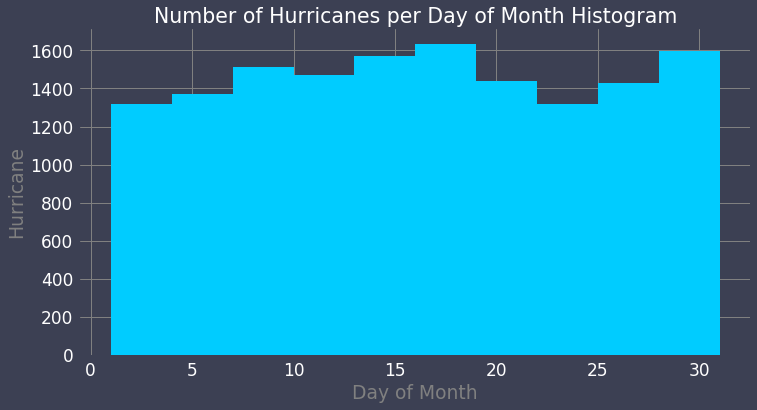

In [16]:
plt.figure(figsize=(12, 6))
data[(data.day != 99) & (data.status == 'HU')].day.plot(kind='hist', color='#00CCFF')
plt.title("Number of Hurricanes per Day of Month Histogram")
plt.xlabel("Day of Month")
plt.ylabel("Hurricane")
plt.show()

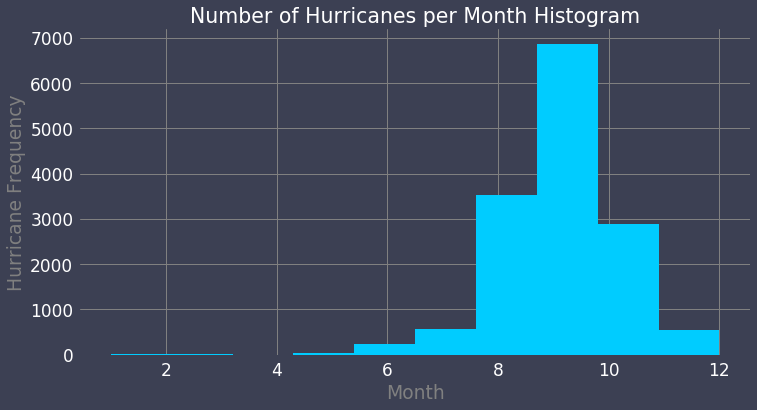

In [17]:
plt.figure(figsize=(12, 6))
data[(data.day != 99) & (data.status == 'HU')].month.plot(kind='hist', color='#00CCFF')
plt.title("Number of Hurricanes per Month Histogram")
plt.xlabel("Month")
plt.ylabel("Hurricane Frequency")
plt.show()

Over 90% of hurricanes in the North Atlantic Basin occurred in August, September, and October

In [18]:
data[(data.day != 99) & ((data.month == 8) | (data.month == 9) | (data.month == 10)) &
     (data.status == 'HU')].shape[0] / data[(data.day != 99) & 
                                            (data.status == 'HU')].shape[0]

0.9042647560559536

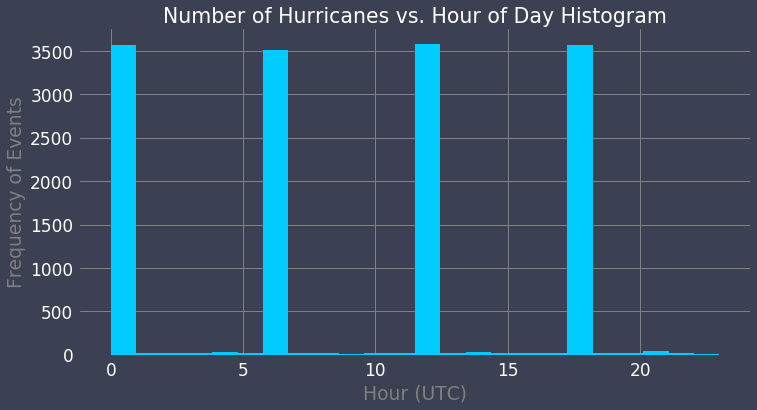

In [19]:
plt.figure(figsize=(12, 6))
data[(data.day != 99) & (data.status == 'HU')].hour.plot(kind='hist', bins=24, color='#00CCFF')
plt.title("Number of Hurricanes vs. Hour of Day Histogram")
plt.xlabel("Hour (UTC)")
plt.ylabel("Frequency of Events")
plt.show()

This shows the recorded hour of the hurricane. This reflects data logging techniques.

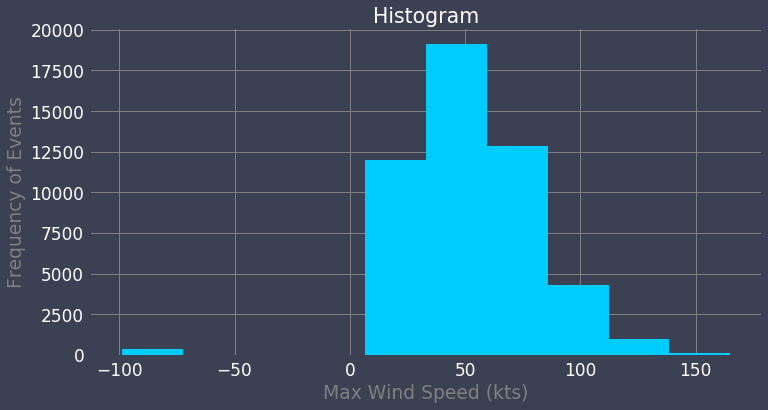

In [20]:
plt.figure(figsize=(12, 6))
data[(data.day != 99)].max_wind.plot(kind='hist', color='#00CCFF')
plt.title("Histogram")
plt.xlabel("Max Wind Speed (kts)")
plt.ylabel("Frequency of Events")
plt.show()

The max wind histogram follows a Poisson distribution

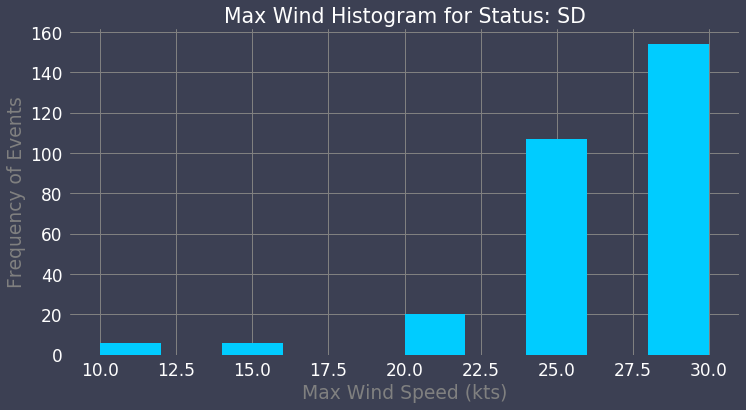

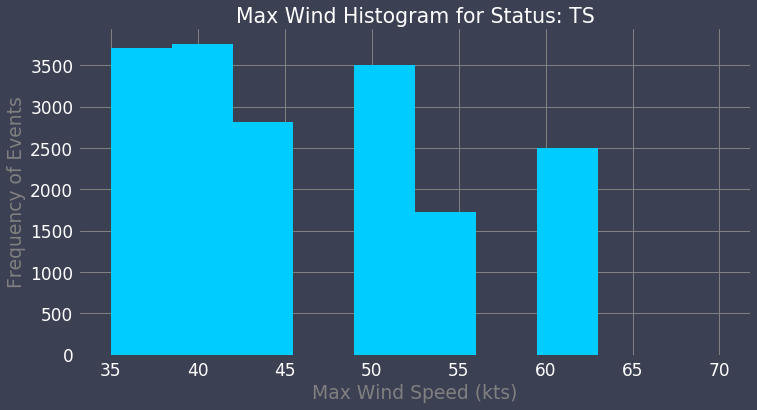

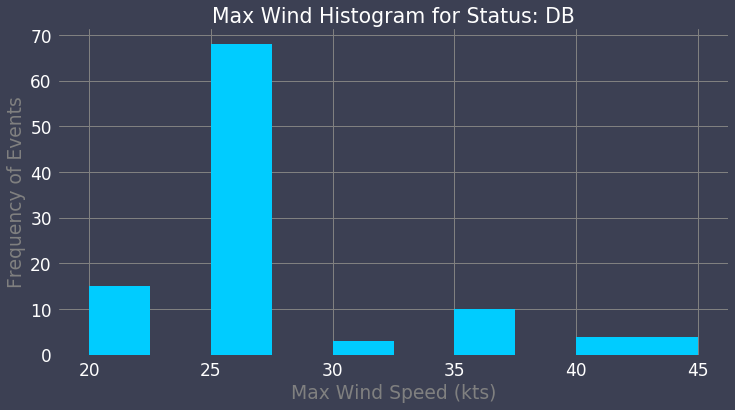

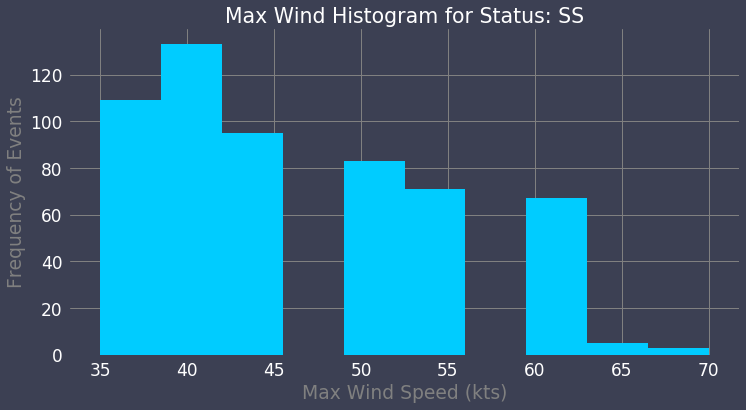

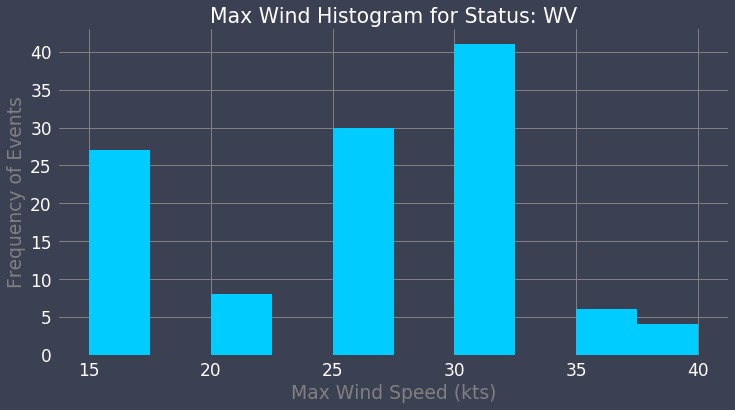

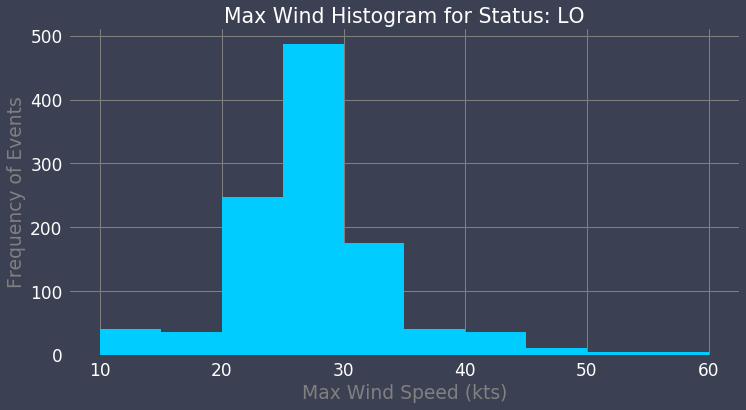

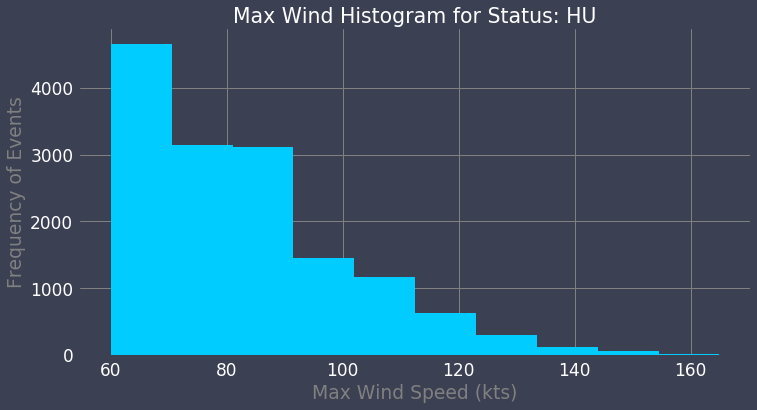

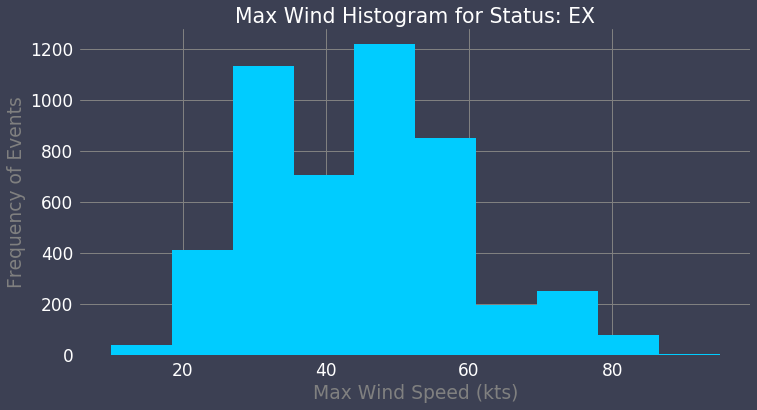

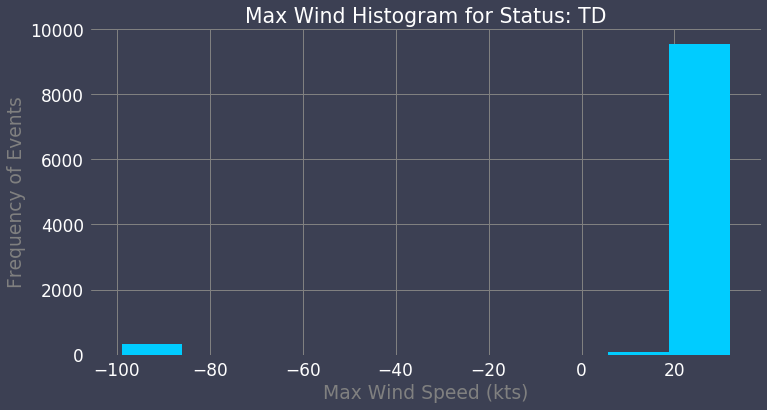

In [21]:
for status in statuses:
    if status != 'NE':
        plt.figure(figsize=(12, 6))
        data[(data.day != 99) & (data.status == status)].max_wind.plot(kind='hist',
                                                                       color='#00CCFF')
        plt.title("Max Wind Histogram for Status: {}".format(status))
        plt.xlabel("Max Wind Speed (kts)")
        plt.ylabel("Frequency of Events")
        plt.show()

According to the histogram, hurricance's max wind speed is less than 100 kts most of the time

There are over 300 missing max wind speed measurements for tropic depressions

In [22]:
data[(data.day != 99) & (data.status == 'TD') & (data.max_wind < 0)].max_wind.count()

338

These are the only max wind speed missing values in the dataframe. Let's replace the missing values with the median wind speed value for tropical depressions: 30 kts

In [23]:
data.max_wind = data.max_wind.apply(lambda x: 30 if x == -99 else x)

In [24]:
data[(data.day != 99) & (data.status == 'TD') & (data.max_wind < 0)].max_wind.count()

0

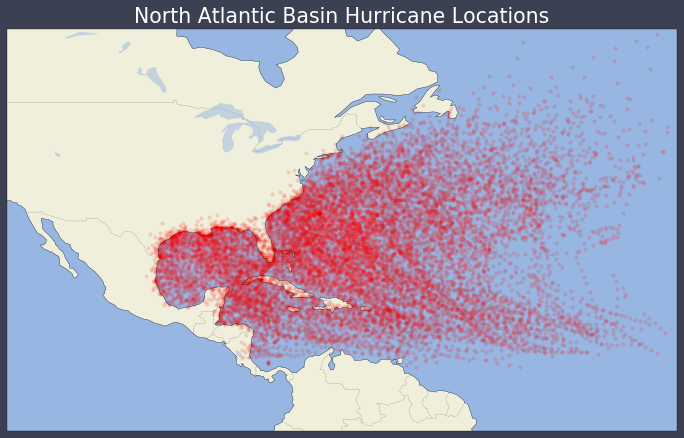

In [25]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-120, -20, 0, 60], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
plt.scatter(data[(data.day != 99) & (data.status == 'HU')].lon,
            data[(data.day != 99) & (data.status == 'HU')].lat,
            marker='.',
            color='#FF0000',
            alpha=0.15)
plt.title('North Atlantic Basin Hurricane Locations')
plt.show()

Let's examine the time between measurements

In [26]:
data.loc[:, 'hour_decimal'] = np.array(data.hour) + np.array(data.minute) / 60
data.loc[:, 'time_diff'] = data.hour_decimal.diff()

In [27]:
(data[(data.day != 99) & (data.time_diff == 6)].time_diff.count()) \
/ (data[(data.day != 99) & (data.time_diff > 0)].time_diff.count())

0.961160775684225

Over 96% of the time, there's a 6-hour gap between measurements

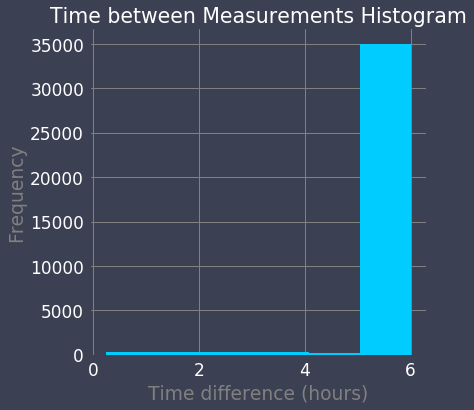

In [28]:
plt.figure(figsize=(6, 6))
data[(data.day != 99) & (data.time_diff > 0)].time_diff.hist(bins=6, color='#00CCFF')
plt.title("Time between Measurements Histogram")
plt.ylabel('Frequency')
plt.xlabel('Time difference (hours)')
plt.show()

Most time gaps are 6 hours

Any multi-collinearity? Yes

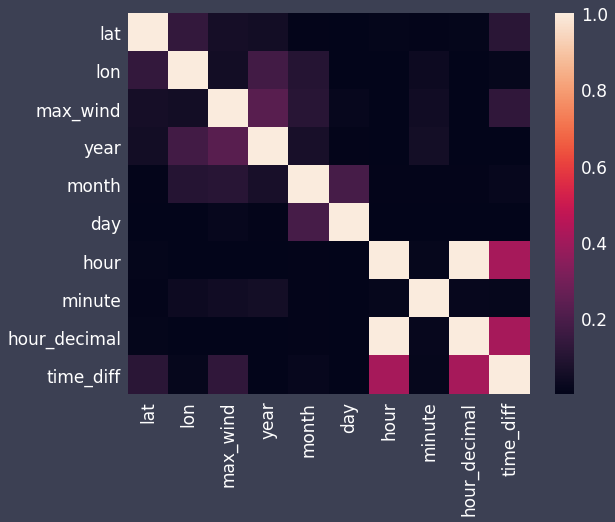

In [29]:
plt.figure(figsize=(9,7))
sns.heatmap(np.abs(data[data.day != 99].corr()));

Let's drop "hour" and "minute" because we created "hour_decimal"

In [30]:
data.drop(['hour', 'minute'], axis=1, inplace=True)

With the exception of "hour_decimal" and "time_diff", the features have little correlation with each other

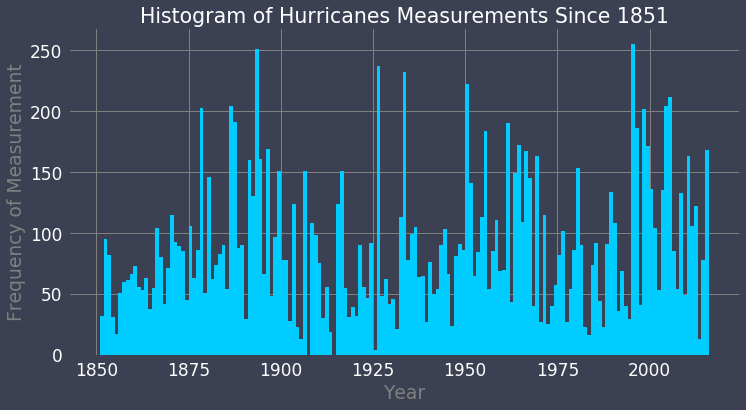

In [31]:
plt.figure(figsize=(12, 6))
data[(data.day != 99) & (data.status == 'HU')].year.plot(kind='hist', bins=165,
                                                         color='#00CCFF')
plt.title("Histogram of Hurricanes Measurements Since 1851")
plt.xlabel("Year")
plt.ylabel("Frequency of Measurement")
plt.show()

Possible sinusoidal pattern. Let's dig deeper.

'HU_years' is the below dataframe that contains measured hurricane (HU) events with maximum wind speed (max_wind) and time duration (time_diff)

In [32]:
HU_years = data[(data.day != 99) & (data.status == 'HU')][['year', 'max_wind', 
                                                                'time_diff']]

Filling in the median time duration for an event's first row

In [33]:
avg_time_diff = HU_years[HU_years.time_diff > 0].time_diff.mean()
HU_years.time_diff = HU_years.time_diff.apply(lambda x: x if x > 0
                                              else avg_time_diff)

An event's first row has no previous reference, so we replaced it with the column's median value

In [34]:
HU_years.head(3)

,year,max_wind,time_diff
1,1851,80,5.802339
2,1851,80,6.000000
3,1851,80,6.000000


Using energy to describe hurricance measuremed strength. Kinetic energy is proportional to $\frac{1}{2} mass \cdot  velocity ^{2}$

Since we do not have the hurricances' mass, we will work with the velocity. The specific kinetic energy is $\frac{1}{2} velocity ^{2}$. We will use the specific kinetic energy as a metric for hurricane's energy.

In [35]:
HU_years.loc[:, 'KE'] = (np.array(HU_years.max_wind)**2) * 0.5

Let's include the time duration by multiplying it with the hurricane's strength. We're assuming the hurricane maintained its strength throughout the measurement's duration.

In [36]:
HU_years.loc[:, 'KE-hours'] = np.array(HU_years.KE) * np.array(HU_years.time_diff)
HU_years.drop(['max_wind', 'time_diff', 'KE'], axis=1, inplace=True)

In [37]:
HU_years.head(3)

,year,KE-hours
1,1851,18567.484788
2,1851,19200.000000
3,1851,19200.000000


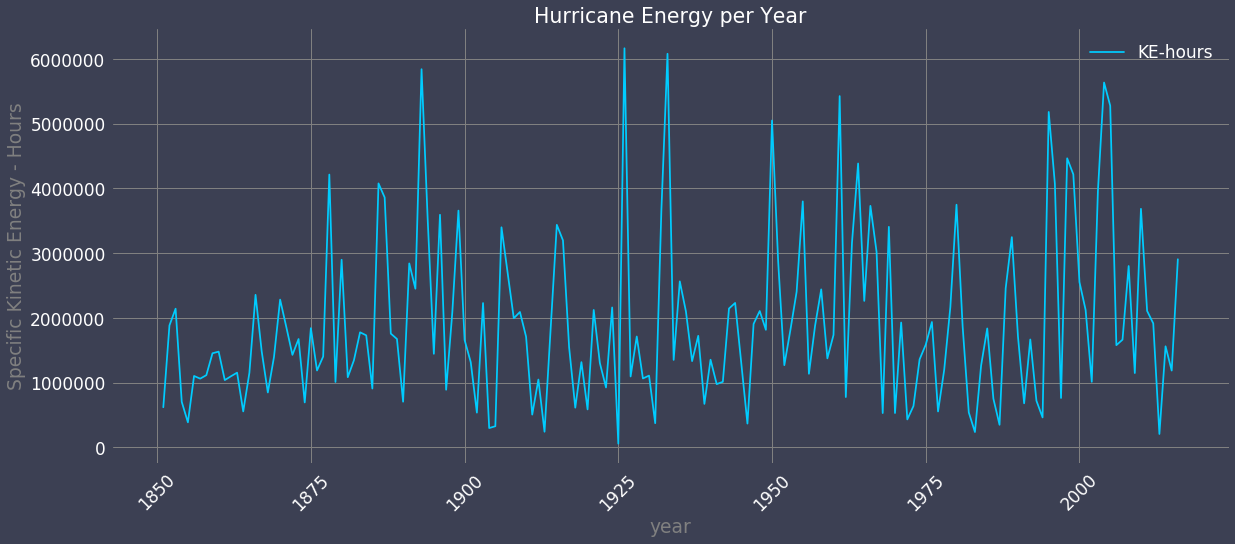

In [38]:
HU_energy_year = HU_years.groupby('year').sum()
HU_energy_year.plot(figsize=(20, 8),
                    rot=45,
                    color='#00CCFF',
                    title='Hurricane Energy per Year')
plt.ylabel('Specific Kinetic Energy - Hours');

At first glance, there appears to be cyclics. Let dig deeper.

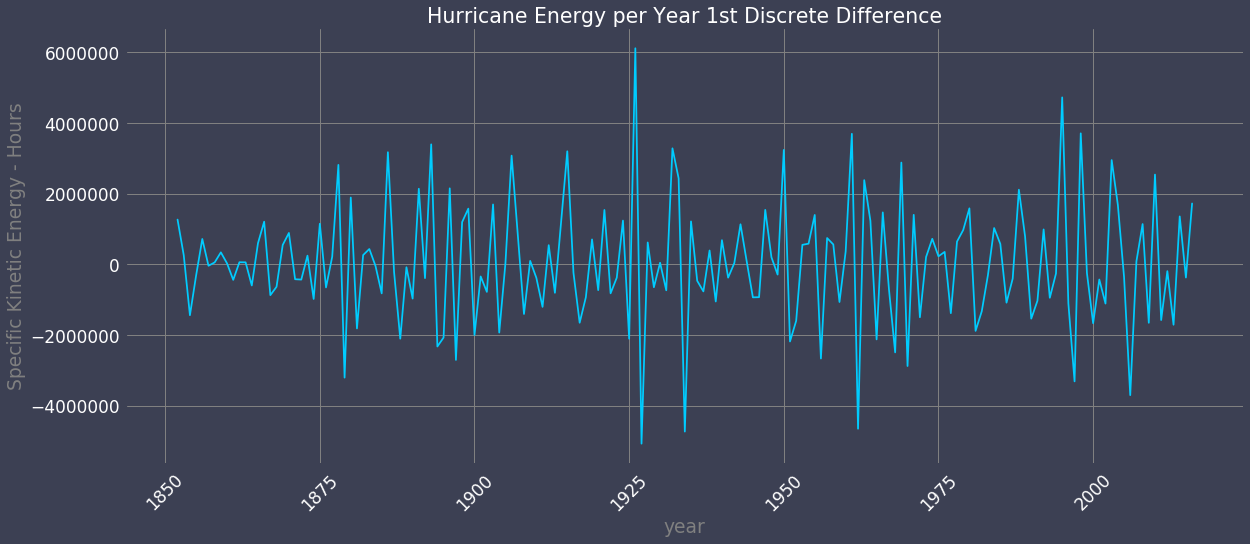

In [39]:
HU_energy_year.loc[:, 'KE-hour-diff'] = HU_energy_year.diff()
HU_energy_year['KE-hour-diff'][1:].plot(figsize=(20, 8),
                                        rot=45,
                                        color='#00CCFF',
                                        title='Hurricane Energy per Year 1st Discrete Difference')
plt.ylabel('Specific Kinetic Energy - Hours');

The plot simply is the difference of the previous year with the current year. Since we have a nice looking stationary plot, let's use time-series analysis to quantify our hunches.

### Time-Series Analysis of Hurricane Energy by Year
For more information about autocorrelations, check out this website https://people.duke.edu/~rnau/411arim3.htm

/home/raven/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


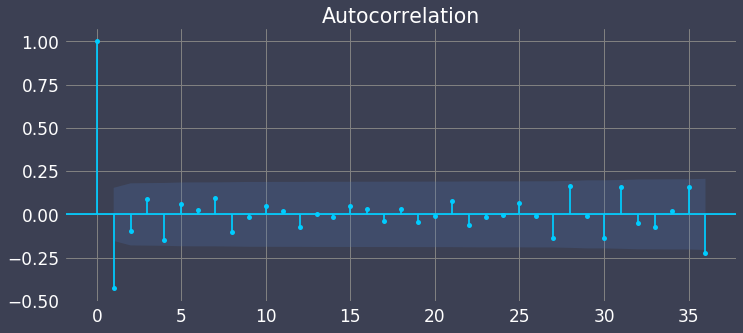

In [40]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(HU_energy_year['KE-hour-diff'][1:], lags=36, ax=ax, color='#00CCFF')
plt.show()

Autocorrelation function calculations the coefficients of correlation between a time series and lags of itself. The statistically significant coefficients help us determine the moving average parameters in a ARIMA model. The coefficients 1 and 36 are statistically significant.

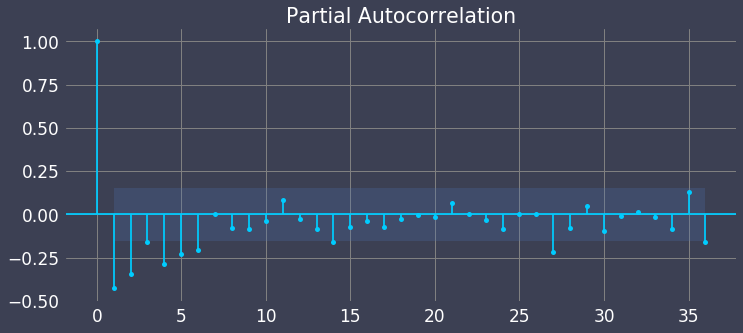

In [41]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(HU_energy_year['KE-hour-diff'][1:], lags=36, ax=ax, color='#00CCFF');

A partial autocorrelation function shows the amount of correlation between a feature and a lag of that feature that is not explained by previous lags. The statistically significant coefficients help determine the auto-regressive parameters. The coefficients 1 through 6, 14, 27, and 36 are statistically significant.

The partial autocorrelation produced several more statistically significant coefficient compared to the autocorrelation function. Therefore, we'll procede with an auto-regressive model.
$$y_i = c + \beta_1  y_{i-1} + \beta_2  y_{i-2}\ +\ ...\ +\ \beta_p  y_{i-p}\ +\ \epsilon \\
y_i =c + \sum_{j=1}^p \beta_j y_{i-j} + \epsilon$$

In [42]:
# Year 1852 to 2016
# Year 1888 is the first non-NaN data with the 36 year shift
y = HU_energy_year['KE-hour-diff'][1:]

Creating a dataframe of lagged to train model to forecast future predictions

In [43]:
# 1 through 6, 14, 27, and 36
ts_df = pd.DataFrame([y.shift(1), y.shift(2), y.shift(3), y.shift(4), y.shift(5), y.shift(6),
                      y.shift(14), y.shift(27), y.shift(36)]).transpose().dropna()
ts_df.columns = ['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag14', 'lag27', 'lag36']
ts_df.head(3)

,lag1,lag2,lag3,lag4,lag5,lag6,lag14,lag27,lag36
year,,,,,,,,,
1888,-2.167525e+05,3.170236e+06,-8.224272e+05,-4.698672e+04,432634.557880,261541.459501,-9.801877e+05,-440100.815486,1.264568e+06
1889,-2.104301e+06,-2.167525e+05,3.170236e+06,-8.224272e+05,-46986.723824,432634.557880,1.148592e+06,59025.671275,2.585339e+05
1890,-8.300246e+04,-2.104301e+06,-2.167525e+05,3.170236e+06,-822427.244563,-46986.723824,-6.543491e+05,55796.491506,-1.440190e+06


Create an auto-regressive model

In [44]:
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR

Split the data into a training set and a testing set

In [45]:
X = ts_df.drop(['lag14'], axis=1)    # Removing the 14-year lag term improves score
yy = y[36:]
X_train, X_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state=42)

Standardize features

In [46]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

Linear Regression

In [47]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
print('R-squared score: {}'.format(round(model.score(X_test, y_test), 3)))

R-squared score: 0.503


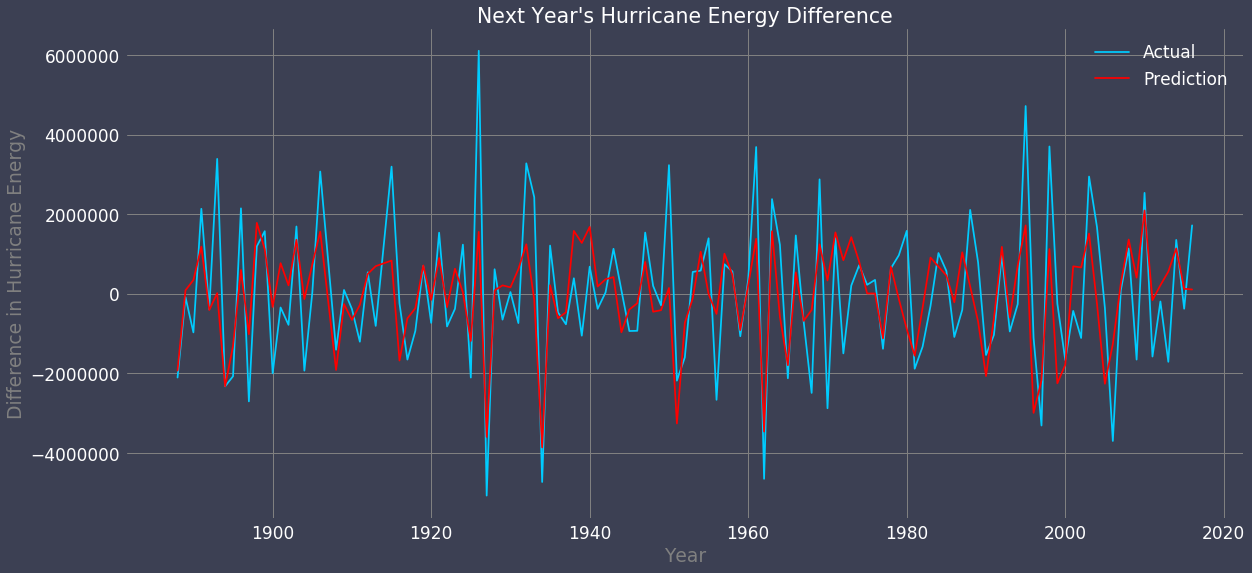

In [48]:
diff_preds = model.predict(ss.fit_transform(X))
actual = yy.values

plt.figure(figsize=(20, 9))
plt.plot(yy.index, actual, label='Actual', color='#00CCFF')
plt.plot(yy.index, diff_preds, label='Prediction',
         color='#FF0000')
plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('Difference in Hurricane Energy')
plt.title('Next Year\'s Hurricane Energy Difference');

In [49]:
dirvec = [1 for x in np.sign(yy.values) - np.sign(model.predict(ss.fit_transform(X))) if x==0]
round(sum(dirvec) / len(yy.values), 2)

0.75

The auto-regressive model predicts an increase or decrease (energy change directionality - increase or decrease) with ~75% accuracy

### Predicting Hurricane Hit Zones

Housekeeping with the time difference feature

In [50]:
data.time_diff = data.time_diff.apply(lambda x: x + 24 if x < 0 else x)
data.time_diff = data.time_diff.apply(lambda x: 6 if x < 0 else x)

Binary classification of whether or not a measurement happened in a zone (see map at top of notebook)

In [51]:
data['lat_lon'] = list(zip(data.lat, data.lon))
data.loc[:, 'A'] = data.lat_lon.apply(lambda x: 1 if (28.0 > x[0] >= 25.9) & 
                                      (-99.1 < x[1] <= -95.9) else 0)
data.loc[:, 'B'] = data.lat_lon.apply(lambda x: 1 if (30.9 > x[0] >= 28.0) & 
                                      (-97.6 < x[1] <= -92.4) else 0)
data.loc[:, 'C'] = data.lat_lon.apply(lambda x: 1 if (31.2 > x[0] >= 28.9) & 
                                      (-92.4 < x[1] <= -88.5) else 0)
data.loc[:, 'D'] = data.lat_lon.apply(lambda x: 1 if (31.4 > x[0] >= 28.9) & 
                                      (-88.5 < x[1] <= -85.1) else 0)
data.loc[:, 'E'] = data.lat_lon.apply(lambda x: 1 if (31.2 > x[0] >= 28.9) & 
                                      (-85.0 < x[1] <= -79.9) else 0)
data.loc[:, 'F'] = data.lat_lon.apply(lambda x: 1 if (28.9 > x[0] >= 26.7) & 
                                      (-83.3 < x[1] <= -80.0) else 0)
data.loc[:, 'G'] = data.lat_lon.apply(lambda x: 1 if (26.7 > x[0] >= 24.4) & 
                                      (-82.6 < x[1] <= -79.0) else 0)
data.loc[:, 'H'] = data.lat_lon.apply(lambda x: 1 if (34.0 > x[0] >= 31.2) & 
                                      (-82.4 < x[1] <= -78.3) else 0)
data.loc[:, 'I'] = data.lat_lon.apply(lambda x: 1 if (37.4 > x[0] >= 34.0) & 
                                      (-80.7 < x[1] <= -75.4) else 0)
data.loc[:, 'J'] = data.lat_lon.apply(lambda x: 1 if (41.6 > x[0] >= 37.4) & 
                                      (-78.8 < x[1] <= -72.0) else 0)
data.loc[:, 'K'] = data.lat_lon.apply(lambda x: 1 if (45.4 > x[0] >= 40.7) & 
                                      (-72.0 < x[1] <= -67.5) else 0)

Any overlap between the zones?

In [52]:
data[(data.A + data.B + data.C + data.D + data.E + data.F + data.G + data.H + data.I + \
      data.J + data.K) > 1].count().sum()

0

Pie chart

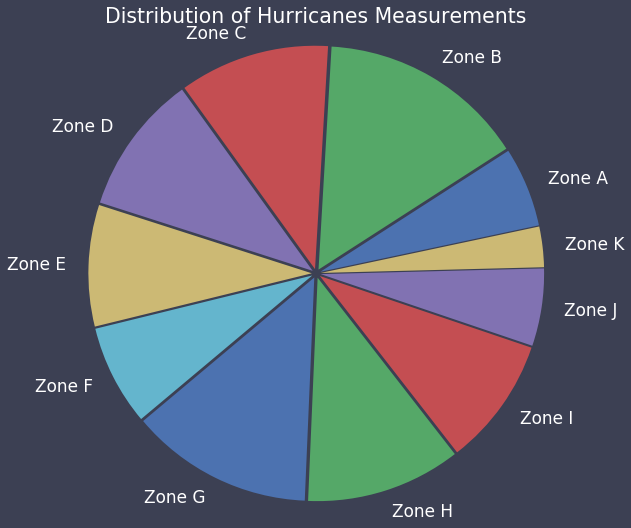

In [53]:
counts = [data[(data[n] == 1) & (data.day != 99) & (data.status == 'HU')][n].count() 
          for n in 'ABCDEFGHIJK']
labels = ['Zone ' + n for n in 'ABCDEFGHIJK']
plt.figure(figsize=(9,9))
plt.pie(counts, labels=labels, startangle=12, explode=np.ones(len(counts))*0.02)
plt.axis('equal')
plt.title('Distribution of Hurricanes Measurements');

Number of measurements per storm

In [54]:
data.reset_index(inplace=True)

Histogram

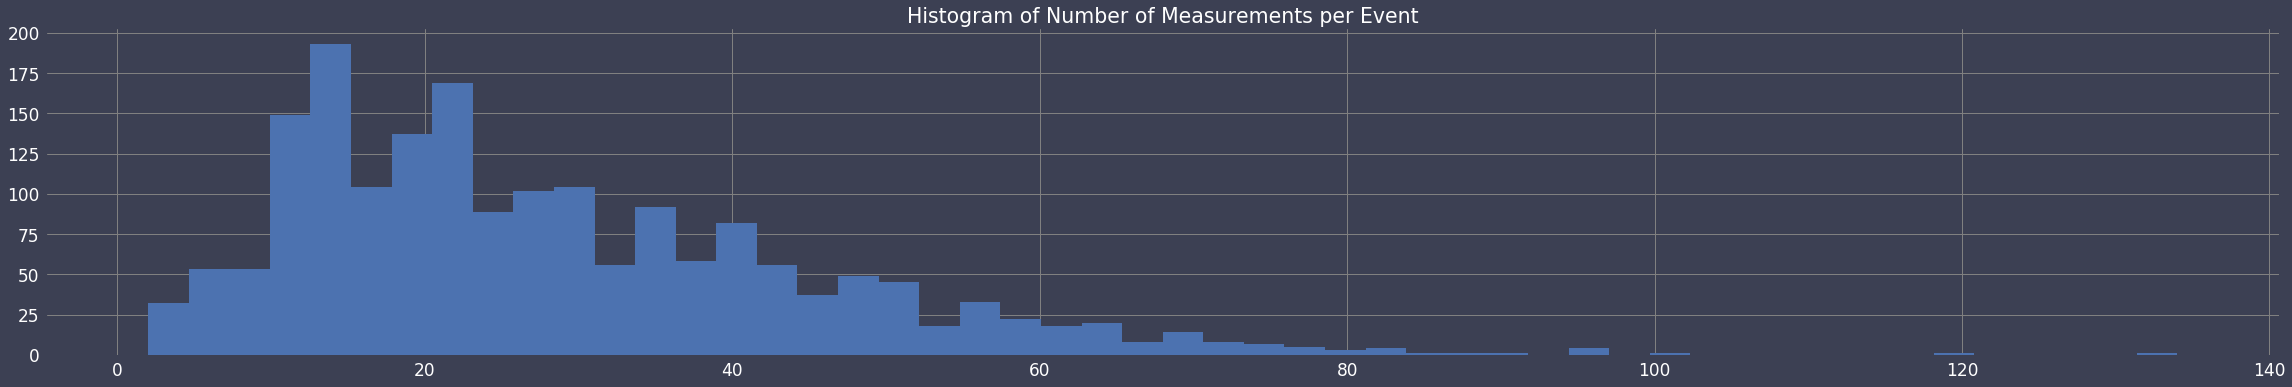

In [55]:
num = []
events_index = np.array(data[data.status == 'NE'].index)
for i in range(1, 1830):
    num.append(events_index[i] - events_index[i - 1])
num += [19]    # Last storm event in dataset
plt.figure(figsize=(40,6))
plt.hist(num, bins=50)
plt.title('Histogram of Number of Measurements per Event');

In order to gain meaningful data, we'll need 8 previous measurement (or about 48 hours of previous position and max energy data)

Creates a "Number of Prior Measurements" for each measurement

In [56]:
num_meas = []
temp = num
for i in data.index:
    if data.status[i] == 'NE':
        count = num[0]
        sub_count = count
        del temp[0]
    else:
        sub_count -= 1
    num_meas.append(count - sub_count)
data.loc[:, 'prior_measures'] = num_meas

Zones each event hit (may be multiple zones)

In [57]:
status_update = []
counter = 0
while counter < 51478:
    if data.status[counter] == 'NE':
        counter += 1
        stop = 0
        stat_ary = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        while data.status[counter] != 'NE' or stop > 150:
            stat_ary += np.array(data[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
                                       'I', 'J', 'K']].iloc[counter])
            counter += 1
            stop += 1
    else:
        print('***************', list(data.iloc[counter]))
        counter += 1
    status_update.append([counter, np.sign(stat_ary)])

In [58]:
status_mat = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
for _ in range(status_update[0][0] - 1):
    status_mat = np.vstack((status_mat, status_update[0][1]))
for i in range(1, len(status_update)):
    for _ in range(status_update[i][0] - status_update[i-1][0]):
        status_mat = np.vstack((status_mat, status_update[i][1]))
status_mat = np.vstack((status_mat, np.array(data[['A', 'B', 'C', 'D', 'E', 'F', 'G',
                                                   'H', 'I', 'J', 'K']].iloc[51480:])))
data[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']] = status_mat

In [59]:
a = {'A':[], 'B':[], 'C':[], 'D':[], 'E':[], 'F':[], 'G':[], 'H':[], 'I':[], 'J':[], 'K':[]}

Create "No Zone" feature if event did not hit any zones